# Lab 06
Antoni Zięciak (zieciak@student.agh.edu.pl)

### 2D advection
Advection in two-dimensional space is described as followed:
$$\frac{\partial f}{\partial x} + u\frac{\partial f}{\partial x} + v\frac{\partial f}{\partial y} = 0$$

Assuming that $u$ and $v$ are constant an analitical solution for any initial state described using function $\psi(x, y)$ after time $t$ will be $\psi(x-ut, y-vt)$.  

In [52]:
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

In [53]:
PARAMS_P = SimpleNamespace(
    n_part=2500,
    norm=1e10,
    dist=multivariate_normal([3, 3], [[1,0],[0,1]]),
)

PARAMS_X = SimpleNamespace(
    span=8,
    n_cell=32,
)

PARAMS_X.step = PARAMS_X.span / PARAMS_X.n_cell
PARAMS_P.n_part1D = np.sqrt(PARAMS_P.n_part).astype(int)

RNG = np.random.default_rng(seed=42)

In [54]:
def sample(*, params_p, params_x, rng):
    helper_dist = norm(loc=3, scale=1)
    u01 = rng.uniform(0, 1, size=params_p.n_part1D)
    uniform_samples = u01 * params_x.span
    constant_samples = helper_dist.ppf(u01)
    return {
        k: {
            "cell_x": np.meshgrid((v["x"]  / PARAMS_X.step).astype(int), (v["y"] / PARAMS_X.step).astype(int))[0],
            "cell_y": np.meshgrid((v["x"]  / PARAMS_X.step).astype(int), (v["y"] / PARAMS_X.step).astype(int))[1],
            "mult": np.round(v["z"] * params_p.norm).astype(int)
        } for k, v in
        {
            "sampling: uniform random in (x, y)" : {
                "x": uniform_samples,
                "y": uniform_samples,
                "z": params_p.dist.pdf(np.dstack(np.meshgrid(uniform_samples, uniform_samples))) * params_x.span ** 2 / params_p.n_part
            },
            "sampling: constant multiplicity": {
                "x": constant_samples,
                "y": constant_samples,
                "z": np.full(shape=(params_p.n_part1D, params_p.n_part1D), fill_value=1 / params_p.n_part)
            }
        }.items()
    }

PARTICLES = sample(params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

In [55]:
def plot(*, particles, params_p, params_x, rng, shift_x=0, shift_y=0):
    _, axs = plt.subplot_mosaic(
        [["normal"], ["const"], ["part"]],
        figsize=(10, 20),
        per_subplot_kw={"normal":{"projection":"3d"}, "const":{"projection":"3d"}}
    )
    
    u01 = rng.uniform(0, 1, params_p.n_part1D)
    u02 = rng.uniform(0, 1, params_p.n_part1D)
    scale = params_p.norm / params_p.n_part

    pdf_x = np.linspace(0, 8, 32)
    pdf_y = np.linspace(0, 8, 32)
    PDF_X, PDF_Y = np.meshgrid(pdf_x, pdf_y)
    pos = np.dstack((PDF_X - shift_x, PDF_Y - shift_y))
    Z = params_p.dist.pdf(pos)
    axs["normal"].plot_wireframe(PDF_X / params_x.step, PDF_Y / params_x.step, Z * params_x.step)
    axs["const"].plot_wireframe(PDF_X / params_x.step, PDF_Y / params_x.step, Z * params_x.step)

    for k, label in zip(particles, ("normal", "const")):
        xpos = particles[k]["cell_x"]
        ypos = particles[k]["cell_y"]
        xpos = xpos.flatten()
        ypos = ypos.flatten()
        mult = particles[k]["mult"].flatten() / params_p.norm
        hist, xedges, yedges = np.histogram2d(xpos, ypos, bins=params_x.n_cell, range=[[0, params_x.n_cell], [0, params_x.n_cell]], weights=mult)
        x, y = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
        x = x.ravel()
        y = y.ravel()
        z = 0
        dx = dy = 1 * np.ones_like(z)
        dz = hist.ravel()
        axs[label].bar3d(x, y, z, dx, dy, dz, zsort="max", alpha=0.666, color="orange")

        X = particles[k]["cell_x"]
        Y = particles[k]["cell_y"]
        axs["part"].scatter(X + u01, Y + u02, s=0.25 + 2 * particles[k]["mult"] / scale)

    for ax in axs.values():
        ax.set_xticks(np.arange(params_x.n_cell+1))
        ax.set_yticks(np.arange(params_x.n_cell+1))

    axs["part"].xaxis.set_tick_params(rotation=75)
    axs["part"].grid()

    plt.show()

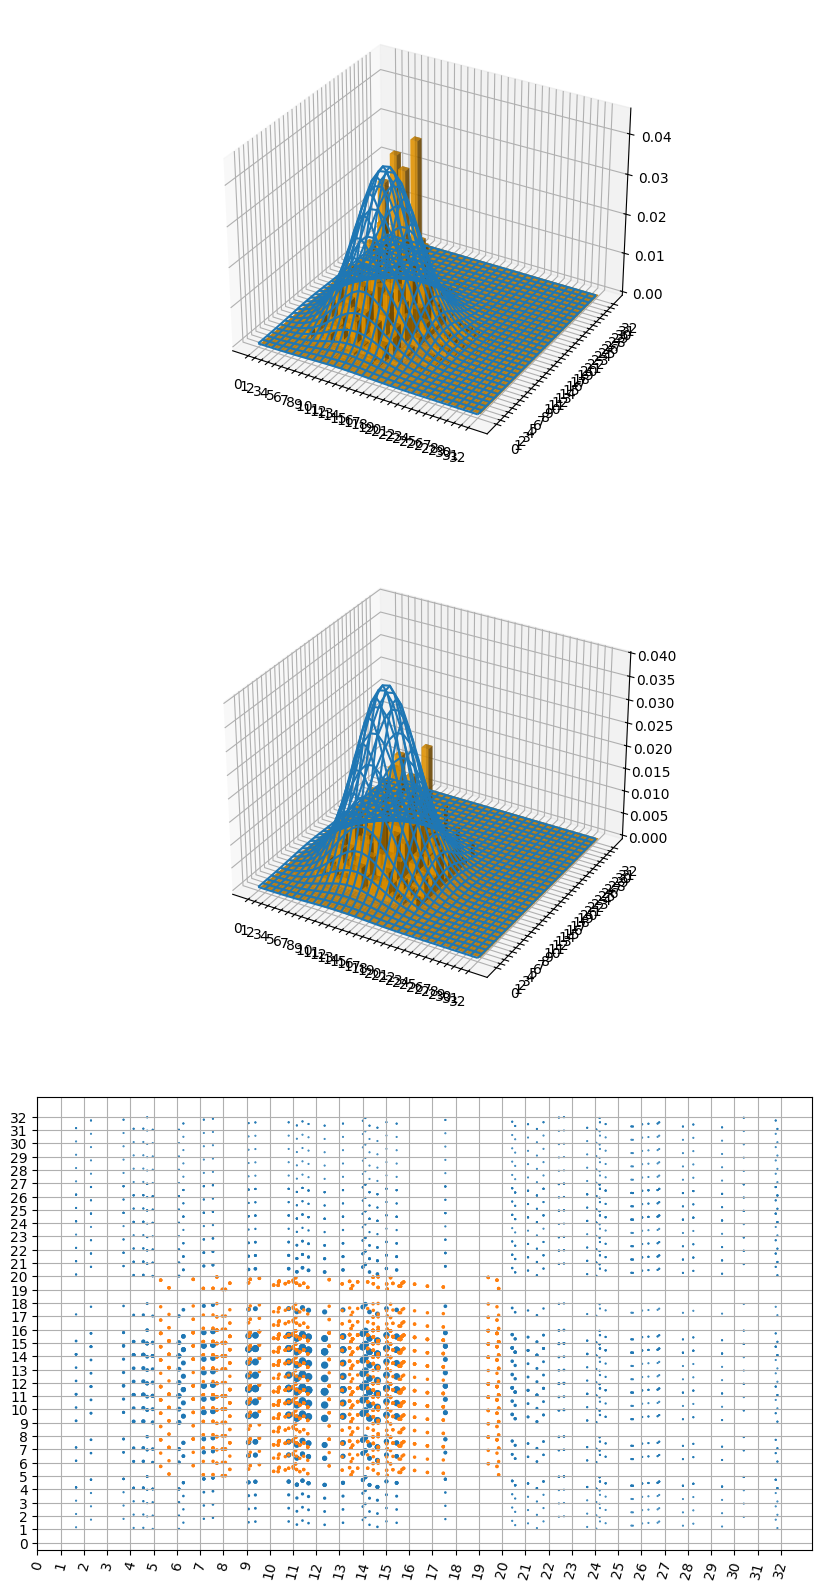

In [56]:
plot(particles=PARTICLES, params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

In [57]:
PARAMS_T = SimpleNamespace(
    span = 1,
    n_step = 30,
    wind_x = 1.5,
    wind_y = 1.5
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_number_x = PARAMS_T.wind_x / PARAMS_X.step * PARAMS_T.step
PARAMS_T.courant_number_y = PARAMS_T.wind_y / PARAMS_X.step * PARAMS_T.step

In [58]:
def advect(*, params_p, params_t, particles, rng):
    """ performs Monte-Carlo advection of the particles """
    probability_of_shift_x = abs(params_t.courant_number_x)
    probability_of_shift_y = abs(params_t.courant_number_y)
    assert probability_of_shift_x < 1
    assert probability_of_shift_y < 1

    sign_x = int(abs(params_t.courant_number_x) / params_t.courant_number_x)
    sign_y = int(abs(params_t.courant_number_y) / params_t.courant_number_y)
    for _ in range(params_t.n_step):
        u01_x = rng.uniform(0, 1, size=(params_p.n_part1D, params_p.n_part1D))
        u01_y = rng.uniform(0, 1, size=(params_p.n_part1D, params_p.n_part1D))
        for part in particles.values():
            part["cell_x"] += (probability_of_shift_x > u01_x) * sign_x
            part["cell_y"] += (probability_of_shift_y > u01_y) * sign_y

advect(particles=PARTICLES, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)

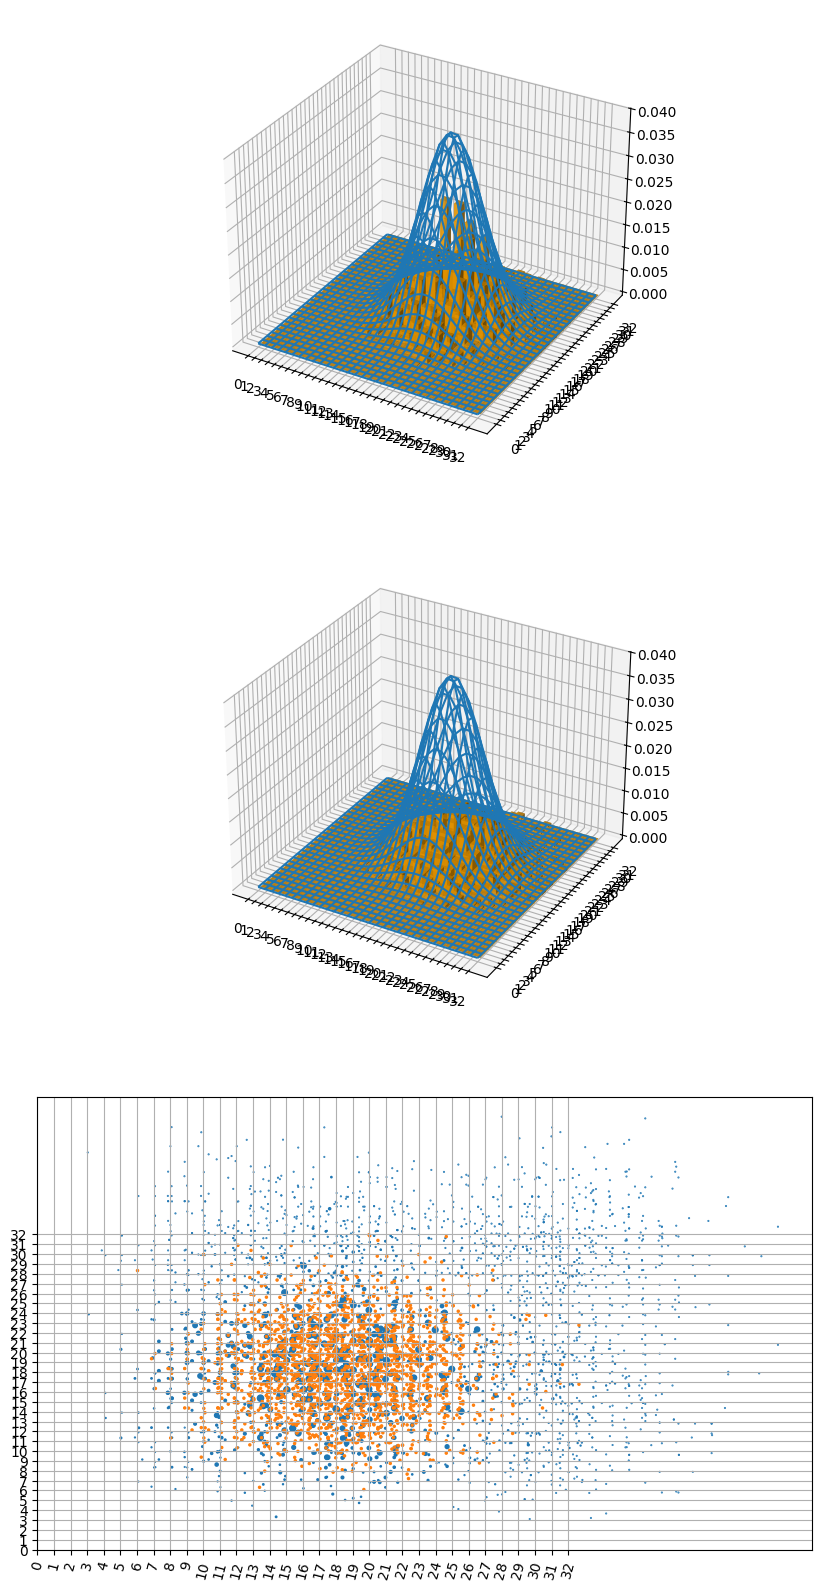

In [59]:
plot(
    particles=PARTICLES,
    params_p=PARAMS_P, 
    params_x=PARAMS_X, 
    rng=RNG, 
    shift_x=PARAMS_T.wind_x * PARAMS_T.span, 
    shift_y=PARAMS_T.wind_y * PARAMS_T.span
)